# Install necessary package

In [1]:
# install necessary package
# timm for ViT pre-trained weight
!pip install --user timm
!pip install --user seaborn
!pip install --user pytest-shutil
!pip install --user scikit-image
!pip install --user tqdm
!pip install --user opencv-python
!pip install --user torch einops yacs kornia

In [2]:
#load libraries
import os
import numpy as np
import cv2
import json
import skimage.io as io
import shutil
import os
from matplotlib import pyplot as plt
import seaborn as sns
import csv


import torch
import torchvision 
import torch.nn.functional as F  
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm 
from random import sample
import copy

/home/chenanf/.local/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# File Structure
For running this code, you need to have the following file structure in your google drive (MyDrive).
```
root/
    train.csv
    test.csv (imagenames.csv)
    README.md
    code.ipynb
    train_img/
        ... (all training image here)
    test_img/
        ... (all test image here)
    
    
```

# Set up path

In [3]:
rootpath = r"/CV_final_project_1021261&1087032/"
# Please access this folder here "https://drive.google.com/drive/folders/1RgMBLT8QGwgrI4d1e7xaNuQiWKAxYHZg?usp=sharing"

'''
Image Dir
'''

train_img_dir = os.path.join(rootpath, r"train_img")
test_img_dir = os.path.join(rootpath, r"test_img")

'''
CSV Dir
'''
train_csv_path = os.path.join(rootpath, "train.csv")
test_csv_path = os.path.join(rootpath, "imagenames.csv")



# Create pytorch dataset for our task

In [4]:
# Load Image Data
import os
import pandas as pd 
import torch
from torch.utils.data import Dataset
#from skimage import io
from PIL import Image
import torchvision.transforms as transforms

class trainDataset(Dataset):
    '''
    csv_file contain the image name and the label (x,y) of each image
        first column: name of the image
        second column: label (the x,y coordinations) of the image
    img_dir: the path to where the train or test images are stored
    flag_resize (bool): a flag, if True, then do the resize. Resize the image into suqare.
    img_resize (int): the width of image to be resized to
    cmap: how the image should be read
    
    '''
    def __init__(self, csv_file, img_dir, flag_resize=True, img_size=224, transform=None, cmap='RGB'):
        self.annotations = pd.read_csv(csv_file) #read csv as dataframe
        self.img_dir = img_dir
        self.img_names = self.annotations['id'].to_numpy() #array of object, size: (7500,)
        self.flag_resize = flag_resize
        self.img_size = img_size
        self.transform = transform
        self.cmap = cmap
    
    
    def __len__(self):
        return len(self.img_names)
        

    def __getitem__(self, index):
        img_filename = self.img_names[index] + ".jpg" #output will look like this ('IMG2760_5.jpg',)
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert(self.cmap) # w, h, channel #image raed by PIL is channel last. shape(490, 680, 3)
        
        geo_label_x = (self.annotations.iloc[index,1])
        geo_label_y = (self.annotations.iloc[index,2])
        
        
        #Resize PIL image to square
        if self.flag_resize:
            ori_img_width = image.size[0]
            ori_img_height = image.size[1]
            image = image.resize((self.img_size,self.img_size),resample=Image.LANCZOS) #LANCZOS is the best
      
        
        
        if self.transform: #transforms.ToTensor() convert PIL image into a tensor with shape (channel, height, width)
            image = self.transform(image) #after convert to tensor it is channel first (shape: 3,490,680)



        return (img_filename, image, (geo_label_x, geo_label_y))
    
    '''
    This function is used to get the id, x, and y of spdcific image in the dataset by its image file name
    Return:
        ID (str)
        image
        x, y (tensor.float)
    '''
    def get_item_by_imgName(self, imgName):
        dataframe = self.annotations
        imgID = imgName.strip('.jpg')
        out = dataframe[dataframe['id'] == imgID] #out is a dataframe that contain 3 columns: 'id', 'x', 'y'
        ID = out.iloc[0,0]
        assert ID==imgID
        x = out.iloc[0,1]
        y = out.iloc[0,2]
        
        img_path = os.path.join(self.img_dir, imgName)
        image = Image.open(img_path).convert(self.cmap) # w, h, channel #image raed by PIL is channel last. shape(490, 680, 3)
        
        if self.transform:
            image = self.transform(image)
        return (ID, image, x, y)
        
        
        


'''
This dataset is used for test. Because during the test time, we don't have the label (x,y)
'''
class testDataset(Dataset):
    '''
    csv_file contain the image name and the label (x,y) of each image
        first column: name of the image
        
    img_dir: the path to where the train or test images are stored
    flag_resize (bool): a flag, if True, then do the resize. Resize the image into suqare.
    img_resize (int): the width of image to be resized to
    cmap: how the image should be read
    
    '''
    def __init__(self, csv_file, img_dir, flag_resize=True, img_size=224, transform=None, cmap='RGB'):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.img_names = self.annotations['id'].to_numpy() #array of object, size: (7500,)
        self.flag_resize = flag_resize
        self.img_size = img_size
        self.transform = transform
        self.cmap = cmap
   
    def __len__(self):
        return len(self.img_names)
        

    def __getitem__(self, index):
        img_filename = self.img_names[index] + ".jpg"
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert(self.cmap) # w, h, channel #image raed by PIL is channel last. shape(490, 680, 3)
        
        #Resize PIL image to square
        if self.flag_resize:
            ori_img_width = image.size[0]
            ori_img_height = image.size[1]
            image = image.resize((self.img_size,self.img_size),resample=Image.LANCZOS) #LANCZOS is the best
      
        
        
        if self.transform: #transforms.ToTensor() convert PIL image into a tensor with shape (channel, height, width)
            image = self.transform(image) #after convert to tensor it is channel first (shape: 3,490,680)

        return (img_filename, image)
    
    def get_item_by_imgName(self, imgName):
        dataframe = self.annotations
        imgID = imgName.strip('.jpg')
        out = dataframe[dataframe['id'] == imgID] #out is a dataframe that contain 3 columns: 'id', 'x', 'y'
        ID = out.iloc[0,0]
        assert ID==imgID
        #x = out.iloc[0,1]
        #y = out.iloc[0,2]
        
        img_path = os.path.join(self.img_dir, imgName)
        image = Image.open(img_path).convert(self.cmap) # w, h, channel #image raed by PIL is channel last. shape(490, 680, 3)
        
        if self.transform:
            image = self.transform(image)
       
        return (ID, image)
        
    
    

# ViT Model for feature extraction and similarity score computation

In [5]:
'''
This cell is the main module of the vision transformer.
The code is extracted from https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py
'''

import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square). 

    patch_size : int
        Size of the patch (it is a square). 

    in_chans : int
        Number of input channels.
        RGB: 3
        Gray scale: 1

    embed_dim : int
        The emmbedding dimension.
        This embed_dim stays constant across entire network.
        how big the embedding of our patch

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=1024):
        super().__init__()
        self.img_size = img_size #assume square image, image_size = the length of the image (int)
        self.patch_size = patch_size #assume square, patch_size = the length of the patch (int)
        self.n_patches = (img_size // patch_size) ** 2 # total number of patches (flatten)


        #kernel will exactly fall into the patches and never overlap.
        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`. #n_samples also called batch size

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        # feed x to proj layer
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5) #64 patch -> 8x8
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim) #swap the axis

        return x

# Below code are just copied from NLP

class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors.
        

    proj_p : float 
        Dropout probability applied to the output tensor.
        

    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.
        Split into query, key and value
            q represents the previous output
            k,v is the hidden state

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads 
        self.scale = self.head_dim ** -0.5 #come from "attention is all you need paper" to prevent too large head to dominant

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) #linear mapping, take the embedding token and mapping/split to query, key, value
        #input size = (?,?,dim) output size = (?,?,3*dim) #linear mapping applied to the last dimension

        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim) #take the concatenate heads #input size = dim #output size = dim

        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`. #include the CLS token as the 1st token of the sequence

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        
        # create extra dimension for heads and q,k,v
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        
        # change the order
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim) 

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t #matrix multiplication
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        
        #apply softmax to get discrete probabilities that some up to 1. This can be use as the weight.
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1) 
        attn = self.attn_drop(attn) #dropout

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim) #compute the weighted average
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim) #flatten(2), start flatten from axis 2
        # dim = n_heards x head_dim

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim) #dropout

        return x


class MLP(nn.Module):
    """Multilayer perceptron.

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU
        GELU activation function. #Gaussian Error Linear Units function

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features) 

        return x


class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6) #Applies Layer Normalization over a mini-batch of inputs
        
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        #remove the mlp layer
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x)) #residule (add x to output)
        x = x + self.mlp(self.norm2(x)) #residule (add x to output)

        return x


class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of transformer blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules. # a list that hold all the modules

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1, #output dimension
            embed_dim=1024,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) #3D
        #nn.Parameter is a kind of Tensor that is to be considered a module parameter.

        # determine where is exactly the location of the given patch in the image
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim) #1+ for CLS token
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6) #normalize over the lasr axis (which size is embed_dim)
        self.projEmb = nn.Linear(embed_dim, n_classes) #self.head
        
        

    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x) #turn input image x into patch embedding


        # learnable cks token
        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)

        # prepend to the patch embedding
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        # add the learnable location embedding 
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x) # (n_samples, 1 + n_patches, embed_dim)

        x = self.norm(x) # (n_samples, 1 + n_patches, embed_dim)

        
        # for classification task
        cls_token_final = x[:, 0] #only take the CLS token to represent the whole image 
        
        x = cls_token_final #shape [batch_size, 768(embed_dim)]
        return x

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import numpy as np
import timm
import torch

# load pre-trained model
model_name = "vit_base_patch32_224"
model_official = timm.create_model(model_name, pretrained=True).to(device)
model_official.eval() #switch to eval mode
print(type(model_official))

custom_config = {
        "img_size": 224,
        "in_chans": 3,
        "patch_size": 32,
        "embed_dim": 768,
        "depth": 12, 
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
        "n_classes": 1
}

model_custom = VisionTransformer(**custom_config).to(device)
model_custom.eval() #set to evaluation mode

# Copy pre-trained weight to our customer model

In [8]:
# copy the pretrained weighted into our customer model
for n_o, p_o in model_official.named_parameters():
    for n_c, p_c in model_custom.named_parameters():
        if n_o == n_c:
            print(n_o)
            p_c.data[:] = p_o.data #copy the pre-trained parameters to our model
            


# Set to eval mode for feature extraction

In [11]:
model_custom.eval()

# Prediction

In [12]:
import torch
import torchvision
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader 
from tqdm import tqdm
from random import sample
import copy

In [13]:
img_transform = transforms.Compose([
        transforms.ToTensor(), #transform image from [0,1] PIL Image into a tensor
        transforms.Normalize(mean=torch.tensor([0.5000, 0.5000, 0.5000]), std=torch.tensor([0.5000, 0.5000, 0.5000])) #transform image into [-1,1] #(three value for three channel)
])


# Initialize the dataset

In [14]:
# For ViT: image feature extraction for simlarity measurement
# The image is read as tensor with value in [-1,1]
# train_dataset is the whole 7500 image in "COMP90086_2021_Project_train"
train_dataset = trainDataset(csv_file = train_csv_path, img_dir = train_img_dir, flag_resize=True, img_size = 224, transform = img_transform)
test_dataset = testDataset(csv_file = test_csv_path, img_dir = test_img_dir, flag_resize=True, img_size = 224, transform = img_transform)


# del_set and valid_set is for develop feature matching algorithm purpose!
# cmap="L" meas read image as grayscale
# the image is convert to tensor with value in [0,1]
train_dataset_original_size = trainDataset(csv_file = train_csv_path, img_dir = train_img_dir, flag_resize=False, 
                                           img_size = None, transform = transforms.ToTensor(), cmap='L') #return image is channel first, value between [0,1]

test_dataset_original_size = testDataset(csv_file = test_csv_path, img_dir = test_img_dir, flag_resize=False, 
                                           img_size = None, transform = transforms.ToTensor(), cmap='L') #return image is channel first, value between [0,1]



dev_set, valid_set = torch.utils.data.random_split(train_dataset_original_size, [6750, 750]) #10% for validation

# Initialize the dataloader

In [17]:
batch_size = 1

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## Predict the similarity score or load the pre-computed similarity score

In [19]:
# run ViT prediction to predict the similarity score
flag_pred = False

if flag_pred:
    
    # run ViT prediction on the whole train images to get their feature vectors
    pred_train = dict()
    for batch_idx, (filename, img, point) in enumerate(tqdm(train_loader)):
        with torch.no_grad():
            img = img.to(device=device)
            out = model_custom(img)
            filename = filename[0] #convert ('IMG2760_5.jpg',) to 'IMG2760_5.jpg'
            pred_train[filename] = out
    
    # run ViT prediction on the whole test images to get their feature vectors
    pred_test = dict()
    for batch_idx, (filename, img) in enumerate(tqdm(test_loader)): #TODO: need to write test_loader, need to write a new class for test class
        with torch.no_grad():
            img = img.to(device=device)
            out = model_custom(img)
            filename = filename[0]
            pred_test[filename] = out
    
    # measure the similarity by compute the feature vectors' cosine similarity
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # compute the similarity of pair of training images
    sim_dic = dict()
    for filename1, output1 in tqdm(pred_train.items()):
        #filename1 = filename1[0] #TODO: why need [0] here?
        sim_dic[filename1] = dict()
        for filename2, output2 in pred_train.items():
            #filename2 = filename2[0]
            if filename1 != filename2:
                sim = cos(output1,output2) #sim is look likes tensor([0.5782], device='cuda:0')
                sim_dic[filename1][filename2] = sim.item()
    # sort the similarity from highest to lowest
    for key in sim_dic.keys(): #key is the image name
        sim_dic[key] = dict(sorted(sim_dic[key].items(), key=lambda item: item[1], reverse=True))
    
    test_sim_dic = dict()
    # compute the similarity between train image and test iamge
    for filename1, output1 in tqdm(pred_test.items()):
        filename1 = filename1
        test_sim_dic[filename1] = dict()
        for filename2, output2 in pred_train.items():
            filename2 = filename2
            if filename1 != filename2:
                sim = cos(output1,output2)
                test_sim_dic[filename1][filename2] = sim.item()
    # sort the similarity from highest to lowest   
    for key in test_sim_dic.keys(): #test image name
        test_sim_dic[key] = dict(sorted(test_sim_dic[key].items(), key=lambda item: item[1], reverse=True))
    
    # Save the similarity dict to json file
    #with open('train_sim_dic.json', 'w') as file:
    #    file.write(json.dumps(sim_dic))
        
    with open("train_sim_dic.json", "w") as outfile:
        json.dump(sim_dic, outfile)

    with open('test_sim_dic.json', 'w') as outfile:
        json.dump(test_sim_dic, outfile)
    


    

## Load the pre-computed similarity score?

In [20]:
flag_load_similarity_files = True
train_sim_dic_path = os.path.join(rootpath, 'train_sim_dic.json')
test_sim_dic_path = os.path.join(rootpath, 'test_sim_dic.json')


if flag_load_similarity_files:
    with open(train_sim_dic_path) as f:
        sim_dic = json.load(f)
    with open(test_sim_dic_path) as f:
        test_sim_dic = json.load(f)
    

In [21]:
'''
Input:
    img (str): 
        the file name of the image
    sim_dic:
        shoud be sim_dic (contain the similarity score between every 2 training images) or 
        test_sim_dic (contain the similarity scoer between test iamge and train image)
    n_top (int): 
        how many result you want to find.
        If threshold = None, then the output will be determined by n_top
    threshold (float): 
        if threshold is not None, then n_top will be ignored. The output will be determined by threshold
        the similarity score. only keep the image with score higher than this thershold
    img_name_to_exclude (list):
        all_image_names_in_val_set or all_image_names_in_dev_set
        during the devlop time, we want to find the similar images between develop set and val set.
        We don't want to find the similar images within the develop set or the val set itself.
        Therefore, this list is used to avoid finding similar image in the dataste itself.

Output:
    top_dict (dictionary): a dictionary that contain the name of image as key, the simialrity score as values.
    This dictionary only keep the top similar images.
'''
def find_top_similar_imgs(img, sim_dic, n_top = 10, threshold = None, img_name_to_exclude=[]):
    cnt = 0
    top_imgs = []
    top_values = []
    for img2 in sim_dic[img].keys():
        if img2 in img_name_to_exclude:
            continue
        # determined by n_top
        if threshold != None:
            if sim_dic[img][img2] >= threshold:
                top_imgs.append(img2)
                top_values.append(sim_dic[img][img2])
        # determined by threshold
        else:
            top_imgs.append(img2)
            top_values.append(sim_dic[img][img2])
            cnt += 1
            if cnt == n_top:
                break
    
    zipped = zip(top_imgs, top_values)
    top_dict = dict(zipped)
    
    return top_dict
          
            

In [25]:
'''
Input:
    imgname0 (str)
    imgname1 (str)
    img0: single channel gray scale image, channel first
    img1: single channel gray scale image, channl first
    pts0 [list]: a list of points to plot on image 0
    pts1 [list]: a list of points to plot on image 1
'''
%matplotlib inline
def drawMatchingPts(imgname0, imgname1, img0, img1, pts0, pts1):
    %matplotlib inline
    assert len(pts0) == len(pts1)

    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)
    
    
    fig.figsize=(8, 6)
    #fig.dpi=200

    ax0.imshow(img0[0,:,:], cmap='gray')
    ax2.imshow(img0[0,:,:], cmap='gray')
    ax1.imshow(img1[0,:,:], cmap='gray')
    ax3.imshow(img1[0,:,:], cmap='gray')
    for i in range(len(pts0)):
        pt0 = pts0[i]
        pt1 = pts1[i]
        edgecolor = tuple(np.random.uniform(0,1,3).tolist())
        ax0.plot(pt0[0],pt0[1],marker='.',mec=edgecolor, mfc=(1, 1, 1, 0))
        ax1.plot(pt1[0],pt1[1],marker='.',mec=edgecolor, mfc=(1, 1, 1, 0))

    ax0.title.set_text("T "+" "+imgname0)
    ax1.title.set_text("C "+" "+imgname1)

    plt.show()
    plt.close()


In [26]:
'''
Input:
    img0: the source image. Must be a grayscale image, channel first
    img1: the target image to match. Must be a grayscale image, channel first
        The input image with the shape (1,h,w)
    threshold (float): a value in [0,1]. It is the threshold to filter bad matching points
'''
def get_matched_points_by_loftr(img0, img1, threshold):
    # Add batch axis
    img0 = img0.unsqueeze(0)
    img1 = img1.unsqueeze(0)
    
    from kornia.feature import LoFTR
    loftr = LoFTR('indoor')
    input = {"image0": img0, "image1": img1}
    out = loftr(input)
    # out is a dict with keys: dict_keys(['keypoints0', 'keypoints1', 'confidence', 'batch_indexes'])
    pts_img0 = out['keypoints0']
    pts_img1 = out['keypoints1']
    confidence = out['confidence']
    filter = (confidence>threshold)
    good_pts_img0 = pts_img0[filter]
    good_pts_img1 = pts_img1[filter]
    return good_pts_img0, good_pts_img1
    
    

In [27]:
def predict_xy_from_camera_pose(img_name, img, sim_dic, img_name_to_exclude, n_top=10, loftr_threshold = 0.9, flag_plot = False):

    # find the top simillar (with score larger than 0.7) image in dev_set
    top_dict = find_top_similar_imgs(img = img_name, sim_dic = sim_dic, n_top=n_top, 
        threshold=None, img_name_to_exclude=img_name_to_exclude) # remove the similarity image that is in valid_set (only compare with image in dev_set)
    
    # no similar images found --> not likely to happen
    if len(top_dict) == 0:
        print("warning, there is no similar image for {}".format(img_name))
        return(False, False, False, False)
    max_n_good_recover = 0
    max_n_good_E = 0
    predict_x_recover = -1000
    predict_y_recover = -1000
    predict_x_E = -1000
    predict_y_E = -1000
    skipped_c_imgs = set()
    
    for c_img_name in tqdm(top_dict.keys()):
            
        c_imageID, c_img, c_x, c_y = train_dataset_original_size.get_item_by_imgName(c_img_name)
        good_pts_img, c_good_pts_img = get_matched_points_by_loftr(img, c_img, loftr_threshold)
        
        if flag_plot:
            drawMatchingPts(img_name, c_img_name, img, c_img, good_pts_img, c_good_pts_img) 
        
        if len(good_pts_img) < 6: #need at least 6 point to get 3x3 E
            print("Not enough point for essential matrix computation") 
            skipped_c_imgs.add(c_img_name)
            continue
        
        
        E, mask = cv2.findEssentialMat(np.array(c_good_pts_img), 
                               np.array(good_pts_img), 
                               threshold = 0.1,
                               
                               )
        if E.shape != (3,3) or E is None:
            print("E is not found")
            skipped_c_imgs.add(c_img_name)
            continue
                               
                               
        n_good_E = len(mask[mask==1]) #number of good points used to find the essential matrix
        
        
        
        [n_good_recover, R, t, _] = cv2.recoverPose(E, np.array(c_good_pts_img), np.array(good_pts_img)) #Norm of R is 1. #Norm of t is 1
        
        if flag_plot:
            print("Number of point used to find essential matrix {}".format(n_good_E))
            print("Number of point used to recover pose {}".format(n_good_recover))
        
        #take the one with most n_good
        if n_good_recover > max_n_good_recover:
            max_n_good_recover = n_good_recover
            predict_x_recover = c_x
            predict_y_recover = c_y
            
        if n_good_E > max_n_good_E:
            max_n_good_E = n_good_E
            predict_x_E = c_x
            predict_y_E = c_y
        
    
    if len(skipped_c_imgs) == len(top_dict):
        print("Not enough loftr points found in all top 10 images.")
        assert predict_x_recover == -1000
        assert predict_y_recover == -1000
        assert predict_x_E == -1000
        assert predict_y_E == -1000
        return (None, None, None, None)
        
    return (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E)

        

# Predict x,y on validation set

In [29]:
#dev_set, valid_set
pred_result_dic_valid = dict()
bad_t_image_valid = []
avg_error_recover_valid = 0
avg_error_E_valid = 0
no_sim_image_valid = []
large_error_image_valid = []
for img_name, img, (true_x,true_y) in tqdm(valid_set): #img is grayscale tensor, channel first, with value in [0,1]
    #true_x = true_x.item()
    #true_y = true_y.item()
    #skipped_c_imgs = set()
    (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, sim_dic, img_name_to_exclude=[img_name], n_top=10, loftr_threshold = 0.9)
    
        
    if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (False, False, False, False):
        no_sim_image_valid.append(img_name)
    if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (None, None, None, None):
        print("Not enough loftr points found in all top 10 images for {}.".format(img_name))
        print("Lower down the threshold of loftr to 0")
        print("searh top 20 images instead")
        bad_t_image_valid.append(img_name)
        (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, sim_dic, img_name_to_exclude=[img_name], n_top=20, loftr_threshold = 0)

    error_recover = abs(predict_x_recover - true_x) + abs(predict_y_recover - true_y)
    error_E = abs(predict_x_E - true_x) + abs(predict_y_E - true_y)
    
    if error_recover>10 or error_E>10:
        large_error_image_valid.append(img_name)
        
        
    pred_result_dic_valid[img_name] = dict()
    pred_result_dic_valid[img_name]['predict_x_recover'] = predict_x_recover
    pred_result_dic_valid[img_name]['predict_y_recover'] = predict_y_recover
    pred_result_dic_valid[img_name]['error_recover'] = error_recover
    pred_result_dic_valid[img_name]['predict_x_E'] = predict_x_E
    pred_result_dic_valid[img_name]['predict_y_E'] = predict_y_E
    pred_result_dic_valid[img_name]['error_E'] = error_E
    
    avg_error_recover_valid = avg_error_recover_valid + error_recover
    avg_error_E_valid = avg_error_E_valid + error_E

avg_error_recover_valid = avg_error_recover_valid / len(valid_set)
avg_error_E_valid = avg_error_E_valid / len(valid_set)


In [30]:
# Save the prediction result
with open(os.path.join(rootpath, "pred_result_valid.json"), "w") as outfile:
    json.dump(pred_result_dic_valid, outfile)

with open(os.path.join(rootpath,'bad_target_img_valid.json'), 'w') as outfile:
    json.dump(bad_t_image_valid, outfile)
    
with open(os.path.join(rootpath,'no_sim_img_valid.json'), 'w') as outfile:
    json.dump(no_sim_image_valid, outfile)

with open(os.path.join(rootpath,'large_error_image_valid.json'), 'w') as outfile:
    json.dump(large_error_image_valid, outfile)




# Predict x,y on test set

In [31]:
'''
Make prediction on test set!
'''
pred_result_dic_test = dict()
bad_t_image_test = [] #the image that fail to find result with top_10 and loftr_threshold 0.9

no_sim_image_test = [] #the image that has no similar image!

for img_name, img in tqdm(test_dataset_original_size): #img is grayscale tensor, channel first, with value in [0,1]
    #true_x = true_x.item()
    #true_y = true_y.item()
    #skipped_c_imgs = set()
    (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, test_sim_dic, img_name_to_exclude=[], n_top=10, loftr_threshold = 0.9)
    
        
    if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (False, False, False, False):
        no_sim_image_test.append(img_name)
    if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (None, None, None, None):
        print("Not enough loftr points found in all top 10 images for {}.".format(img_name))
        print("Lower down the threshold of loftr to 0")
        print("searh top 20 images instead")
        bad_t_image_test.append(img_name)
        (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, test_sim_dic, img_name_to_exclude=[], n_top=20, loftr_threshold = 0)
        if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (None, None, None, None):
            #still can't find
            print("release to top 40")
            (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, test_sim_dic, img_name_to_exclude=[], n_top=40, loftr_threshold = 0)
            
            if (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) == (None, None, None, None):
                #still still can't find
                print("release to top 200")
                (predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, test_sim_dic, img_name_to_exclude=[], n_top=200, loftr_threshold = 0)
              
    pred_result_dic_test[img_name] = dict()
    pred_result_dic_test[img_name]['predict_x_recover'] = predict_x_recover
    pred_result_dic_test[img_name]['predict_y_recover'] = predict_y_recover
    
    pred_result_dic_test[img_name]['predict_x_E'] = predict_x_E
    pred_result_dic_test[img_name]['predict_y_E'] = predict_y_E
    

  0%|          | 0/10 [00:00<?, ?it/s]/home/chenanf/.local/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)

 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.60s/it]

Not enough point for essential matrix computation



  0%|          | 6/1200 [02:52<9:24:55, 28.39s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.83s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.74s/it]

Not enough point for essential matrix computation



  1%|          | 11/1200 [05:17<9:30:55, 28.81s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.70s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.83s/it]

Not enough point for essential matrix computation



  1%|          | 13/1200 [06:13<9:24:53, 28.55s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.52s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.54s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.55s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.54s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4301_3.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 50%|█████     | 10/20 [00:27<00:27,  2.74s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:30<00:24,  2.68s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:33<00:21,  2.64s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:38<00:15,  2.60s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:40<00:12,  2.58s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:43<00:10,  2.56s/it]

Not enough point for essential matrix computation



  1%|▏         | 15/1200 [08:01<14:26:23, 43.87s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.64s/it]

Not enough point for essential matrix computation



  1%|▏         | 16/1200 [08:28<12:48:42, 38.95s/it]

Not enough point for essential matrix computation



  2%|▏         | 18/1200 [09:27<11:08:11, 33.92s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.58s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.55s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.54s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:11,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Not enough point for essential matrix computation



  2%|▎         | 30/1200 [15:15<9:25:10, 28.98s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.49s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.52s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.49s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.50s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.51s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:19<00:04,  2.48s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.49s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4317_2.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:48,  2.53s/it]

Not enough point for essential matrix computation



 10%|█         | 2/20 [00:05<00:45,  2.52s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:42,  2.47s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:09<00:39,  2.49s/it]

Not enough point for essential matrix computation



 25%|██▌       | 5/20 [00:12<00:36,  2.46s/it]

Not enough point for essential matrix computation



 30%|███       | 6/20 [00:14<00:34,  2.49s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:17<00:32,  2.50s/it]

Not enough point for essential matrix computation



 40%|████      | 8/20 [00:19<00:29,  2.48s/it]

Not enough point for essential matrix computation



 45%|████▌     | 9/20 [00:22<00:27,  2.49s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:24<00:24,  2.50s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:27<00:22,  2.48s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:29<00:19,  2.49s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:32<00:17,  2.47s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:34<00:14,  2.49s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:37<00:12,  2.47s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:39<00:09,  2.45s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:42<00:07,  2.44s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:44<00:05,  2.51s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:47<00:02,  2.48s/it]

Not enough point for essential matrix computation



100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.



  2%|▎         | 1/40 [00:02<01:38,  2.52s/it]

Not enough point for essential matrix computation



  5%|▌         | 2/40 [00:05<01:36,  2.53s/it]

Not enough point for essential matrix computation



  8%|▊         | 3/40 [00:07<01:31,  2.48s/it]

Not enough point for essential matrix computation



 10%|█         | 4/40 [00:09<01:29,  2.49s/it]

Not enough point for essential matrix computation



 12%|█▎        | 5/40 [00:12<01:26,  2.46s/it]

Not enough point for essential matrix computation



 15%|█▌        | 6/40 [00:14<01:24,  2.49s/it]

Not enough point for essential matrix computation



 18%|█▊        | 7/40 [00:17<01:22,  2.50s/it]

Not enough point for essential matrix computation



 20%|██        | 8/40 [00:19<01:19,  2.48s/it]

Not enough point for essential matrix computation



 22%|██▎       | 9/40 [00:22<01:17,  2.49s/it]

Not enough point for essential matrix computation



 25%|██▌       | 10/40 [00:24<01:15,  2.51s/it]

Not enough point for essential matrix computation



 28%|██▊       | 11/40 [00:27<01:12,  2.49s/it]

Not enough point for essential matrix computation



 30%|███       | 12/40 [00:30<01:10,  2.53s/it]

Not enough point for essential matrix computation



 32%|███▎      | 13/40 [00:32<01:07,  2.50s/it]

Not enough point for essential matrix computation



 35%|███▌      | 14/40 [00:35<01:05,  2.51s/it]

Not enough point for essential matrix computation



 38%|███▊      | 15/40 [00:37<01:02,  2.48s/it]

Not enough point for essential matrix computation



 40%|████      | 16/40 [00:39<00:59,  2.47s/it]

Not enough point for essential matrix computation



 42%|████▎     | 17/40 [00:42<00:56,  2.45s/it]

Not enough point for essential matrix computation



 45%|████▌     | 18/40 [00:44<00:54,  2.48s/it]

Not enough point for essential matrix computation



 48%|████▊     | 19/40 [00:47<00:51,  2.46s/it]

Not enough point for essential matrix computation



 50%|█████     | 20/40 [00:49<00:49,  2.48s/it]

Not enough point for essential matrix computation



 52%|█████▎    | 21/40 [00:52<00:47,  2.50s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 22/40 [00:54<00:44,  2.49s/it]

Not enough point for essential matrix computation



 57%|█████▊    | 23/40 [00:57<00:42,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 24/40 [00:59<00:39,  2.48s/it]

Not enough point for essential matrix computation



 62%|██████▎   | 25/40 [01:02<00:37,  2.50s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 26/40 [01:04<00:34,  2.48s/it]

Not enough point for essential matrix computation



 68%|██████▊   | 27/40 [01:07<00:31,  2.46s/it]

Not enough point for essential matrix computation



 70%|███████   | 28/40 [01:09<00:29,  2.45s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 30/40 [01:14<00:25,  2.53s/it]

Not enough point for essential matrix computation



 78%|███████▊  | 31/40 [01:17<00:22,  2.50s/it]

Not enough point for essential matrix computation



 80%|████████  | 32/40 [01:19<00:20,  2.52s/it]

Not enough point for essential matrix computation



 82%|████████▎ | 33/40 [01:22<00:17,  2.53s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 34/40 [01:24<00:15,  2.51s/it]

Not enough point for essential matrix computation



 88%|████████▊ | 35/40 [01:27<00:12,  2.48s/it]

Not enough point for essential matrix computation



 90%|█████████ | 36/40 [01:29<00:09,  2.49s/it]

Not enough point for essential matrix computation



 92%|█████████▎| 37/40 [01:32<00:07,  2.47s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 38/40 [01:34<00:04,  2.46s/it]

Not enough point for essential matrix computation



 98%|█████████▊| 39/40 [01:37<00:02,  2.48s/it]

Not enough point for essential matrix computation



  3%|▎         | 31/1200 [18:09<23:33:59, 72.57s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.74s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.59s/it]

Not enough point for essential matrix computation



  3%|▎         | 37/1200 [21:02<10:50:43, 33.57s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.58s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.63s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.59s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.55s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.59s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.78s/it]

Not enough point for essential matrix computation



  4%|▍         | 48/1200 [26:25<9:29:57, 29.69s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.80s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.80s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.59s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.80s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:13,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.58s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.56s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.56s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.55s/it]

Not enough point for essential matrix computation



  5%|▍         | 58/1200 [31:15<8:58:46, 28.31s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.82s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.67s/it]

Not enough point for essential matrix computation



  6%|▌         | 73/1200 [38:37<9:02:11, 28.87s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.57s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.68s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.76s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.54s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.54s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.54s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.55s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4368_2.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:48,  2.54s/it]

Not enough point for essential matrix computation



 25%|██▌       | 5/20 [00:13<00:39,  2.65s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:18<00:33,  2.60s/it]

Not enough point for essential matrix computation



 40%|████      | 8/20 [00:20<00:30,  2.58s/it]

Not enough point for essential matrix computation



 45%|████▌     | 9/20 [00:23<00:28,  2.57s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:25<00:25,  2.58s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:31<00:20,  2.58s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:41<00:10,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:47<00:05,  2.63s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:49<00:02,  2.61s/it]

Not enough point for essential matrix computation



  7%|▋         | 82/1200 [43:50<13:34:51, 43.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.71s/it]

Not enough point for essential matrix computation



  7%|▋         | 84/1200 [44:49<11:14:13, 36.25s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.69s/it]

Not enough point for essential matrix computation



  8%|▊         | 98/1200 [51:37<8:48:58, 28.80s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.64s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.60s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.59s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.81s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.68s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.85s/it]

Not enough point for essential matrix computation



  9%|▉         | 111/1200 [57:53<8:45:19, 28.94s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.68s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.63s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.59s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.58s/it]

Not enough point for essential matrix computation



  9%|▉         | 112/1200 [58:20<8:33:05, 28.30s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.72s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.66s/it]

Not enough point for essential matrix computation



 11%|█         | 127/1200 [1:05:43<8:38:31, 28.99s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.59s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.69s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.60s/it]

Not enough point for essential matrix computation



 11%|█         | 134/1200 [1:09:06<8:26:47, 28.53s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.79s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 12%|█▏        | 138/1200 [1:11:03<8:27:35, 28.68s/it]

Not enough point for essential matrix computation



 12%|█▏        | 145/1200 [1:14:32<8:48:01, 30.03s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.65s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.62s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.59s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.71s/it]

Not enough point for essential matrix computation



 13%|█▎        | 153/1200 [1:18:24<8:26:50, 29.05s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.85s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.71s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.81s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.61s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.69s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.62s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.84s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.66s/it]

Not enough point for essential matrix computation



 14%|█▍        | 170/1200 [1:26:38<8:08:22, 28.45s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.76s/it]

Not enough point for essential matrix computation



 14%|█▍        | 173/1200 [1:28:03<8:06:26, 28.42s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.71s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.86s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.77s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.81s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.73s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.60s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.71s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.72s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.77s/it]

Not enough point for essential matrix computation



 16%|█▌        | 193/1200 [1:37:42<8:00:15, 28.62s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.79s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 17%|█▋        | 202/1200 [1:42:07<8:08:58, 29.40s/it]

Not enough point for essential matrix computation



 17%|█▋        | 203/1200 [1:42:36<8:07:53, 29.36s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.86s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 18%|█▊        | 213/1200 [1:47:28<7:49:23, 28.53s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.55s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:14,  2.48s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.44s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:09,  2.47s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.48s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:04,  2.45s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.48s/it]

Not enough point for essential matrix computation



 18%|█▊        | 214/1200 [1:47:53<7:31:47, 27.49s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.63s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.79s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.69s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.60s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.60s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.50s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.67s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.61s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.79s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

Not enough point for essential matrix computation



 20%|██        | 240/1200 [2:00:23<7:42:01, 28.88s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.79s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.78s/it]

Not enough point for essential matrix computation



 20%|██        | 246/1200 [2:03:17<7:32:59, 28.49s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.80s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.69s/it]

Not enough point for essential matrix computation



 21%|██▏       | 256/1200 [2:08:09<7:35:59, 28.98s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.80s/it]

Not enough point for essential matrix computation



 22%|██▏       | 263/1200 [2:11:32<7:30:54, 28.87s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 22%|██▎       | 270/1200 [2:14:56<7:24:27, 28.67s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.82s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.84s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.83s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:18<00:11,  2.95s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

Not enough point for essential matrix computation



 24%|██▎       | 282/1200 [2:20:51<7:26:43, 29.20s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.82s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.66s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.62s/it]

Not enough point for essential matrix computation



 24%|██▍       | 289/1200 [2:24:14<7:17:32, 28.82s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.70s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.68s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.81s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.53s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.54s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.68s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.78s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.66s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.83s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.72s/it]

Not enough point for essential matrix computation



 25%|██▌       | 300/1200 [2:29:29<7:08:51, 28.59s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.85s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:23,  2.95s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.66s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.56s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.55s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Not enough point for essential matrix computation



 26%|██▌       | 306/1200 [2:32:20<6:59:38, 28.16s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.74s/it]

Not enough point for essential matrix computation



 26%|██▌       | 314/1200 [2:36:11<7:06:42, 28.90s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.80s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.82s/it]

Not enough point for essential matrix computation



 27%|██▋       | 324/1200 [2:41:06<7:05:04, 29.11s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.71s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.60s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.76s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.65s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.64s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:23,  2.59s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.56s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.63s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.60s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.58s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.52s/it]

Not enough point for essential matrix computation



 29%|██▊       | 344/1200 [2:50:47<6:36:38, 27.80s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.75s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.53s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.56s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.55s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.55s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.55s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.54s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4647_4.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 75%|███████▌  | 15/20 [00:42<00:13,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:50<00:05,  2.63s/it]

Not enough point for essential matrix computation



 30%|███       | 361/1200 [3:00:01<10:29:31, 45.02s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.79s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.85s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.75s/it]

Not enough point for essential matrix computation



 31%|███▏      | 375/1200 [3:06:53<6:40:44, 29.14s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.80s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:23,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.68s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.66s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

Not enough point for essential matrix computation



 32%|███▏      | 389/1200 [3:13:44<6:35:44, 29.28s/it]

Not enough point for essential matrix computation



 33%|███▎      | 391/1200 [3:14:42<6:34:05, 29.23s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.77s/it]

Not enough point for essential matrix computation



 33%|███▎      | 392/1200 [3:15:10<6:29:19, 28.91s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.68s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.80s/it]

Not enough point for essential matrix computation



 33%|███▎      | 400/1200 [3:19:04<6:22:27, 28.68s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.62s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.53s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.53s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.53s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4698_4.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 50%|█████     | 10/20 [00:27<00:27,  2.75s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:33<00:21,  2.69s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:38<00:15,  2.57s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:40<00:12,  2.56s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:45<00:07,  2.58s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:50<00:02,  2.55s/it]

Not enough point for essential matrix computation



 34%|███▍      | 412/1200 [3:25:45<9:39:04, 44.09s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.69s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

Not enough point for essential matrix computation



 35%|███▌      | 425/1200 [3:32:02<6:14:16, 28.98s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.70s/it]

Not enough point for essential matrix computation



 36%|███▌      | 430/1200 [3:34:27<6:11:59, 28.99s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.74s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.71s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.61s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:23,  2.59s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.61s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.58s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Not enough point for essential matrix computation



 38%|███▊      | 458/1200 [3:47:59<5:43:11, 27.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.69s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.77s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 39%|███▊      | 464/1200 [3:50:49<5:44:12, 28.06s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.67s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.62s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.66s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.59s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.68s/it]

Not enough point for essential matrix computation



 39%|███▉      | 471/1200 [3:54:09<5:44:38, 28.36s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.71s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.77s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 483/1200 [3:59:55<5:37:57, 28.28s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.81s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.68s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.68s/it]

Not enough point for essential matrix computation



 41%|████      | 492/1200 [4:04:17<5:40:53, 28.89s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.75s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.83s/it]

Not enough point for essential matrix computation



 42%|████▏     | 508/1200 [4:12:12<5:38:57, 29.39s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 43%|████▎     | 511/1200 [4:13:38<5:31:09, 28.84s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.62s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.70s/it]

Not enough point for essential matrix computation



 43%|████▎     | 515/1200 [4:15:31<5:20:49, 28.10s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.77s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.70s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.55s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.54s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.53s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.53s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.54s/it]

Not enough point for essential matrix computation



 43%|████▎     | 519/1200 [4:17:22<5:12:48, 27.56s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.64s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.59s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.63s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.83s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 44%|████▍     | 528/1200 [4:21:42<5:19:48, 28.55s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.63s/it]

Not enough point for essential matrix computation



 44%|████▍     | 531/1200 [4:23:09<5:18:17, 28.55s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.66s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.70s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

Not enough point for essential matrix computation



 44%|████▍     | 534/1200 [4:24:33<5:12:40, 28.17s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.81s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 45%|████▌     | 541/1200 [4:28:00<5:20:24, 29.17s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.69s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 46%|████▌     | 546/1200 [4:30:27<5:15:09, 28.91s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.67s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.68s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.55s/it]

Not enough point for essential matrix computation



 47%|████▋     | 562/1200 [4:38:18<5:04:48, 28.67s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:04<00:19,  2.50s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.58s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.68s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.53s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.66s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.58s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Not enough point for essential matrix computation



 48%|████▊     | 570/1200 [4:42:05<4:53:23, 27.94s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.71s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.69s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.62s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.62s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.61s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.69s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.59s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.58s/it]

Not enough point for essential matrix computation



 49%|████▉     | 587/1200 [4:50:18<4:49:27, 28.33s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.48s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:14,  2.50s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.51s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.51s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.51s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4874_3.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 10%|█         | 2/20 [00:05<00:47,  2.67s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:43,  2.55s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:35<00:18,  2.70s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:46<00:07,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:48<00:05,  2.57s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:50<00:02,  2.56s/it]

Not enough point for essential matrix computation



 49%|████▉     | 588/1200 [4:51:37<7:22:29, 43.38s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:26,  2.90s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.84s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

Not enough point for essential matrix computation



 50%|████▉     | 594/1200 [4:54:33<5:14:11, 31.11s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.49s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.57s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.55s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.81s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.86s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.81s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.72s/it]

Not enough point for essential matrix computation



 50%|█████     | 602/1200 [4:58:23<4:48:24, 28.94s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.71s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.82s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:13,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.63s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.77s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.69s/it]

Not enough point for essential matrix computation



 52%|█████▏    | 628/1200 [5:11:02<4:27:22, 28.05s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.66s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.76s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.58s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.77s/it]

Not enough point for essential matrix computation



 53%|█████▎    | 639/1200 [5:16:16<4:25:41, 28.42s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.76s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.74s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.58s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.60s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.58s/it]

Not enough point for essential matrix computation



 54%|█████▎    | 642/1200 [5:17:41<4:20:32, 28.02s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:11,  2.77s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.68s/it]

Not enough point for essential matrix computation



 54%|█████▍    | 648/1200 [5:20:36<4:24:04, 28.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.75s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.68s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.66s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.65s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:23,  2.93s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.75s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.67s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.67s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.65s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.61s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.62s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.59s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.57s/it]

Not enough point for essential matrix computation



 56%|█████▌    | 667/1200 [5:29:43<4:05:58, 27.69s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:21,  2.40s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.78s/it]

Not enough point for essential matrix computation



 56%|█████▌    | 674/1200 [5:33:07<4:12:57, 28.86s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.71s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.66s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.60s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.57s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.77s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 58%|█████▊    | 694/1200 [5:42:54<4:05:36, 29.12s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.69s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.58s/it]

Not enough point for essential matrix computation



 58%|█████▊    | 695/1200 [5:43:21<3:58:54, 28.39s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:21,  2.39s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.72s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.64s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.58s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.94s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.69s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.81s/it]

Not enough point for essential matrix computation



 59%|█████▊    | 703/1200 [5:47:10<3:54:37, 28.33s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.62s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.54s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.53s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG4994_5.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:47,  2.51s/it]

Not enough point for essential matrix computation



 10%|█         | 2/20 [00:05<00:45,  2.51s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:42,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:10<00:40,  2.51s/it]

Not enough point for essential matrix computation



 25%|██▌       | 5/20 [00:12<00:37,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 6/20 [00:15<00:35,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:25<00:25,  2.52s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:33<00:18,  2.65s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:36<00:15,  2.60s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:38<00:12,  2.58s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:43<00:07,  2.55s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:46<00:05,  2.54s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:48<00:02,  2.53s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.58s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.59s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.66s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.75s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.80s/it]

Not enough point for essential matrix computation



 61%|██████    | 727/1200 [5:59:40<3:50:00, 29.18s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.68s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.77s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.81s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:18<00:11,  2.88s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.59s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.55s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.53s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.52s/it]

Not enough point for essential matrix computation



 63%|██████▎   | 754/1200 [6:12:49<3:31:45, 28.49s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.77s/it]

Not enough point for essential matrix computation



 63%|██████▎   | 755/1200 [6:13:17<3:30:45, 28.42s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.80s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.84s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.72s/it]

Not enough point for essential matrix computation



 63%|██████▎   | 759/1200 [6:15:13<3:31:41, 28.80s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.76s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.62s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.66s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.82s/it]

Not enough point for essential matrix computation



 65%|██████▍   | 775/1200 [6:23:03<3:24:36, 28.89s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.77s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.56s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.78s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Not enough point for essential matrix computation



 66%|██████▋   | 798/1200 [6:34:19<3:17:30, 29.48s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.67s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.75s/it]

Not enough point for essential matrix computation



 67%|██████▋   | 802/1200 [6:36:14<3:10:08, 28.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.77s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.64s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.68s/it]

Not enough point for essential matrix computation



 68%|██████▊   | 812/1200 [6:41:04<3:05:10, 28.63s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.66s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.60s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

Not enough point for essential matrix computation



 68%|██████▊   | 817/1200 [6:43:26<3:01:11, 28.39s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.77s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.64s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.80s/it]

Not enough point for essential matrix computation



 69%|██████▊   | 823/1200 [6:46:21<3:02:45, 29.09s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.84s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.75s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.56s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.50s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.49s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5115_1.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 10%|█         | 2/20 [00:05<00:45,  2.53s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:10<00:40,  2.53s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:17<00:33,  2.55s/it]

Not enough point for essential matrix computation



 40%|████      | 8/20 [00:20<00:30,  2.55s/it]

Not enough point for essential matrix computation



 45%|████▌     | 9/20 [00:22<00:27,  2.49s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:25<00:25,  2.50s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:27<00:22,  2.50s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:32<00:17,  2.53s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:35<00:14,  2.49s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:40<00:10,  2.50s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:45<00:05,  2.53s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:48<00:02,  2.61s/it]

Not enough point for essential matrix computation



 69%|██████▉   | 829/1200 [6:50:01<4:26:38, 43.12s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.77s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

Not enough point for essential matrix computation



 70%|███████   | 842/1200 [6:56:26<2:57:59, 29.83s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.66s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.65s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.58s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.59s/it]

Not enough point for essential matrix computation



 71%|███████▏  | 856/1200 [7:03:19<2:47:37, 29.24s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.62s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.86s/it]

Not enough point for essential matrix computation



 72%|███████▏  | 863/1200 [7:06:42<2:40:42, 28.61s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.69s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.64s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.91s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.72s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.72s/it]

Not enough point for essential matrix computation



 73%|███████▎  | 872/1200 [7:11:03<2:37:19, 28.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.64s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.60s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.52s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.52s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5164_1.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 35%|███▌      | 7/20 [00:19<00:35,  2.69s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:27<00:26,  2.69s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:29<00:23,  2.61s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:35<00:18,  2.65s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:37<00:15,  2.62s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:49<00:05,  2.71s/it]

Not enough point for essential matrix computation



 73%|███████▎  | 878/1200 [7:14:47<3:57:15, 44.21s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.79s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.70s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.71s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.75s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:24<00:05,  2.93s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.80s/it]

Not enough point for essential matrix computation



 74%|███████▍  | 888/1200 [7:19:35<2:33:18, 29.48s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.59s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.63s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.58s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.50s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.64s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.82s/it]

Not enough point for essential matrix computation



 74%|███████▍  | 894/1200 [7:22:27<2:28:21, 29.09s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.76s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.63s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.59s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.81s/it]

Not enough point for essential matrix computation



 76%|███████▌  | 909/1200 [7:29:50<2:19:38, 28.79s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.68s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.60s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.66s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.63s/it]

Not enough point for essential matrix computation



 78%|███████▊  | 930/1200 [7:40:04<2:11:09, 29.15s/it]

Not enough point for essential matrix computation



 78%|███████▊  | 931/1200 [7:40:33<2:10:17, 29.06s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.50s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.60s/it]

Not enough point for essential matrix computation



 78%|███████▊  | 938/1200 [7:43:58<2:05:03, 28.64s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.65s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.77s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.71s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.55s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.57s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.55s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.55s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.57s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.56s/it]

Not enough point for essential matrix computation



 79%|███████▉  | 946/1200 [7:47:51<1:58:11, 27.92s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 79%|███████▉  | 948/1200 [7:48:47<1:56:56, 27.84s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.71s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.59s/it]

Not enough point for essential matrix computation



 80%|███████▉  | 954/1200 [7:51:40<1:56:36, 28.44s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.61s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:26<00:02,  2.76s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.66s/it]

Not enough point for essential matrix computation



 80%|███████▉  | 958/1200 [7:53:34<1:54:41, 28.44s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.53s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5245_1.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 15%|█▌        | 3/20 [00:07<00:44,  2.64s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:10<00:41,  2.59s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:31<00:20,  2.54s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:33<00:17,  2.49s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:36<00:14,  2.50s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:50<00:02,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.53s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.53s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:22,  2.77s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.66s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.69s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.49s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.64s/it]

Not enough point for essential matrix computation



 81%|████████▏ | 976/1200 [8:03:06<1:44:53, 28.10s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.75s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Not enough point for essential matrix computation



 82%|████████▏ | 978/1200 [8:04:00<1:42:18, 27.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.77s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.70s/it]

Not enough point for essential matrix computation



 82%|████████▏ | 982/1200 [8:05:57<1:44:28, 28.75s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Not enough point for essential matrix computation



 82%|████████▏ | 984/1200 [8:06:53<1:41:56, 28.32s/it]

Not enough point for essential matrix computation



 82%|████████▏ | 985/1200 [8:07:22<1:42:21, 28.57s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.80s/it]

Not enough point for essential matrix computation



 82%|████████▎ | 990/1200 [8:09:51<1:42:56, 29.41s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.56s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.56s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.55s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.55s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.66s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.61s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.73s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.73s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.59s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.59s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.52s/it]

Not enough point for essential matrix computation



 84%|████████▎ | 1002/1200 [8:15:31<1:31:35, 27.75s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.68s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.67s/it]

Not enough point for essential matrix computation



 84%|████████▍ | 1007/1200 [8:17:55<1:30:44, 28.21s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.63s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.64s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.69s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.45s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:04<00:19,  2.50s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.48s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:09<00:14,  2.50s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:14<00:10,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.51s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.51s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.52s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5308_2.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:45,  2.40s/it]

Not enough point for essential matrix computation



 10%|█         | 2/20 [00:04<00:44,  2.46s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:41,  2.43s/it]

Not enough point for essential matrix computation



 30%|███       | 6/20 [00:15<00:35,  2.54s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:17<00:32,  2.54s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:30<00:20,  2.57s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:33<00:17,  2.55s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:35<00:15,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:40<00:10,  2.58s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:45<00:05,  2.52s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.53s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:09,  2.48s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:04,  2.50s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.48s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5310_2.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:48,  2.53s/it]

Not enough point for essential matrix computation



 10%|█         | 2/20 [00:05<00:45,  2.52s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:42,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:10<00:40,  2.53s/it]

Not enough point for essential matrix computation



 30%|███       | 6/20 [00:15<00:34,  2.49s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:17<00:32,  2.50s/it]

Not enough point for essential matrix computation



 40%|████      | 8/20 [00:20<00:30,  2.50s/it]

Not enough point for essential matrix computation



 45%|████▌     | 9/20 [00:22<00:27,  2.47s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:24<00:24,  2.45s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:27<00:22,  2.45s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:29<00:19,  2.47s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:32<00:17,  2.45s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:34<00:14,  2.47s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:37<00:12,  2.50s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:42<00:07,  2.51s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:47<00:02,  2.52s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 1024/1200 [8:27:47<2:26:23, 49.91s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.68s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.57s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.71s/it]

Not enough point for essential matrix computation



 86%|████████▋ | 1035/1200 [8:33:04<1:20:18, 29.20s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.71s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.78s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.75s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.73s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:23,  2.56s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.58s/it]

Not enough point for essential matrix computation



 88%|████████▊ | 1055/1200 [8:42:48<1:08:23, 28.30s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.72s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.61s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.63s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.65s/it]

Not enough point for essential matrix computation



 88%|████████▊ | 1057/1200 [8:43:42<1:05:58, 27.68s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.49s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:04<00:19,  2.50s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.44s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:09<00:14,  2.47s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.49s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:14<00:09,  2.46s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.47s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:19<00:04,  2.45s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.47s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5344_5.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



  5%|▌         | 1/20 [00:02<00:47,  2.51s/it]

Not enough point for essential matrix computation



 10%|█         | 2/20 [00:05<00:45,  2.51s/it]

Not enough point for essential matrix computation



 15%|█▌        | 3/20 [00:07<00:41,  2.46s/it]

Not enough point for essential matrix computation



 20%|██        | 4/20 [00:09<00:39,  2.48s/it]

Not enough point for essential matrix computation



 25%|██▌       | 5/20 [00:12<00:37,  2.49s/it]

Not enough point for essential matrix computation



 30%|███       | 6/20 [00:14<00:34,  2.46s/it]

Not enough point for essential matrix computation



 35%|███▌      | 7/20 [00:17<00:32,  2.49s/it]

Not enough point for essential matrix computation



 40%|████      | 8/20 [00:19<00:29,  2.46s/it]

Not enough point for essential matrix computation



 45%|████▌     | 9/20 [00:22<00:27,  2.47s/it]

Not enough point for essential matrix computation



 50%|█████     | 10/20 [00:24<00:24,  2.45s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 11/20 [00:27<00:21,  2.43s/it]

Not enough point for essential matrix computation



 60%|██████    | 12/20 [00:29<00:19,  2.42s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:31<00:16,  2.42s/it]

Not enough point for essential matrix computation



 70%|███████   | 14/20 [00:34<00:14,  2.45s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 15/20 [00:36<00:12,  2.47s/it]

Not enough point for essential matrix computation



 80%|████████  | 16/20 [00:39<00:09,  2.48s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:41<00:07,  2.45s/it]

Not enough point for essential matrix computation



 90%|█████████ | 18/20 [00:44<00:04,  2.47s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 19/20 [00:46<00:02,  2.50s/it]

Not enough point for essential matrix computation



100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.



  2%|▎         | 1/40 [00:02<01:37,  2.49s/it]

Not enough point for essential matrix computation



  5%|▌         | 2/40 [00:04<01:34,  2.50s/it]

Not enough point for essential matrix computation



  8%|▊         | 3/40 [00:07<01:30,  2.45s/it]

Not enough point for essential matrix computation



 10%|█         | 4/40 [00:09<01:28,  2.47s/it]

Not enough point for essential matrix computation



 12%|█▎        | 5/40 [00:12<01:26,  2.48s/it]

Not enough point for essential matrix computation



 15%|█▌        | 6/40 [00:14<01:23,  2.44s/it]

Not enough point for essential matrix computation



 18%|█▊        | 7/40 [00:17<01:21,  2.46s/it]

Not enough point for essential matrix computation



 20%|██        | 8/40 [00:19<01:17,  2.44s/it]

Not enough point for essential matrix computation



 22%|██▎       | 9/40 [00:22<01:16,  2.46s/it]

Not enough point for essential matrix computation



 25%|██▌       | 10/40 [00:24<01:12,  2.43s/it]

Not enough point for essential matrix computation



 28%|██▊       | 11/40 [00:26<01:10,  2.43s/it]

Not enough point for essential matrix computation



 30%|███       | 12/40 [00:29<01:07,  2.41s/it]

Not enough point for essential matrix computation



 32%|███▎      | 13/40 [00:31<01:04,  2.40s/it]

Not enough point for essential matrix computation



 35%|███▌      | 14/40 [00:34<01:03,  2.43s/it]

Not enough point for essential matrix computation



 38%|███▊      | 15/40 [00:36<01:01,  2.46s/it]

Not enough point for essential matrix computation



 40%|████      | 16/40 [00:39<00:59,  2.47s/it]

Not enough point for essential matrix computation



 42%|████▎     | 17/40 [00:41<00:56,  2.45s/it]

Not enough point for essential matrix computation



 45%|████▌     | 18/40 [00:44<00:54,  2.46s/it]

Not enough point for essential matrix computation



 48%|████▊     | 19/40 [00:46<00:52,  2.48s/it]

Not enough point for essential matrix computation



 50%|█████     | 20/40 [00:49<00:49,  2.49s/it]

Not enough point for essential matrix computation



 52%|█████▎    | 21/40 [00:51<00:46,  2.46s/it]

Not enough point for essential matrix computation



 55%|█████▌    | 22/40 [00:54<00:44,  2.47s/it]

Not enough point for essential matrix computation



 57%|█████▊    | 23/40 [00:56<00:42,  2.48s/it]

Not enough point for essential matrix computation



 60%|██████    | 24/40 [00:58<00:39,  2.47s/it]

Not enough point for essential matrix computation



 62%|██████▎   | 25/40 [01:01<00:36,  2.44s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 26/40 [01:03<00:34,  2.43s/it]

Not enough point for essential matrix computation



 68%|██████▊   | 27/40 [01:06<00:31,  2.46s/it]

Not enough point for essential matrix computation



 70%|███████   | 28/40 [01:08<00:29,  2.44s/it]

Not enough point for essential matrix computation



 72%|███████▎  | 29/40 [01:11<00:27,  2.46s/it]

Not enough point for essential matrix computation



 75%|███████▌  | 30/40 [01:13<00:24,  2.47s/it]

Not enough point for essential matrix computation



 78%|███████▊  | 31/40 [01:16<00:22,  2.48s/it]

Not enough point for essential matrix computation



 82%|████████▎ | 33/40 [01:21<00:17,  2.50s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 34/40 [01:23<00:15,  2.50s/it]

Not enough point for essential matrix computation



 88%|████████▊ | 35/40 [01:26<00:12,  2.47s/it]

Not enough point for essential matrix computation



 90%|█████████ | 36/40 [01:28<00:09,  2.46s/it]

Not enough point for essential matrix computation



 92%|█████████▎| 37/40 [01:31<00:07,  2.47s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 38/40 [01:33<00:04,  2.48s/it]

Not enough point for essential matrix computation



 98%|█████████▊| 39/40 [01:36<00:02,  2.49s/it]

Not enough point for essential matrix computation



 88%|████████▊ | 1058/1200 [8:46:34<2:48:21, 71.14s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.71s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.54s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.56s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.71s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.61s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.59s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.48s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:12,  2.60s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.55s/it]

Not enough point for essential matrix computation



 89%|████████▉ | 1067/1200 [8:50:51<1:05:27, 29.53s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.73s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.71s/it]

Not enough point for essential matrix computation



 89%|████████▉ | 1070/1200 [8:52:15<1:01:26, 28.36s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.79s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:20<00:08,  2.80s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.69s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.71s/it]

Not enough point for essential matrix computation



 91%|█████████ | 1088/1200 [9:01:00<54:10, 29.02s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.62s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.58s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.61s/it]

Not enough point for essential matrix computation



 91%|█████████ | 1093/1200 [9:03:24<50:30, 28.32s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.71s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.67s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.63s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.61s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.60s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:23,  2.56s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.57s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:16,  2.67s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.69s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:08,  2.68s/it]

Not enough point for essential matrix computation



 92%|█████████▏| 1099/1200 [9:06:11<46:42, 27.75s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.71s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.63s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:07,  2.60s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.57s/it]

Not enough point for essential matrix computation



 92%|█████████▏| 1100/1200 [9:06:37<45:29, 27.30s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.74s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.60s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:23<00:02,  2.68s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.77s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.74s/it]

Not enough point for essential matrix computation



 93%|█████████▎| 1116/1200 [9:14:24<40:19, 28.80s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

Not enough point for essential matrix computation



 93%|█████████▎| 1121/1200 [9:16:52<38:26, 29.19s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.66s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.71s/it]

Not enough point for essential matrix computation



 94%|█████████▍| 1129/1200 [9:20:45<33:52, 28.63s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.61s/it]

Not enough point for essential matrix computation



 94%|█████████▍| 1132/1200 [9:22:09<31:47, 28.06s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:18,  2.59s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.57s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.60s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.63s/it]

Not enough point for essential matrix computation



 95%|█████████▌| 1141/1200 [9:26:27<27:55, 28.40s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.70s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.79s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:20,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:20<00:05,  2.52s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:22<00:02,  2.52s/it]

Not enough point for essential matrix computation



100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


Not enough point for essential matrix computation
Not enough loftr points found in all top 10 images.
Not enough loftr points found in all top 10 images for IMG5434_1.jpg.
Lower down the threshold of loftr to 0
searh top 20 images instead



 40%|████      | 8/20 [00:21<00:32,  2.70s/it]

Not enough point for essential matrix computation



 65%|██████▌   | 13/20 [00:35<00:18,  2.64s/it]

Not enough point for essential matrix computation



 85%|████████▌ | 17/20 [00:45<00:07,  2.63s/it]

Not enough point for essential matrix computation



 96%|█████████▌| 1148/1200 [9:30:39<38:00, 43.85s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.65s/it]

Not enough point for essential matrix computation



 40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.60s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:19<00:07,  2.66s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.53s/it]

Not enough point for essential matrix computation



 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:27<00:02,  2.80s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.77s/it]

Not enough point for essential matrix computation



 98%|█████████▊| 1173/1200 [9:42:53<13:19, 29.61s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.67s/it]

Not enough point for essential matrix computation



 98%|█████████▊| 1174/1200 [9:43:21<12:36, 29.11s/it]

Not enough point for essential matrix computation



 98%|█████████▊| 1179/1200 [9:45:47<10:11, 29.11s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:08<00:18,  2.71s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:15<00:14,  2.92s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:23<00:05,  2.82s/it]

Not enough point for essential matrix computation



 60%|██████    | 6/10 [00:17<00:11,  2.82s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:25<00:02,  2.76s/it]

Not enough point for essential matrix computation



100%|█████████▉| 1198/1200 [9:55:06<00:58, 29.19s/it]

Not enough point for essential matrix computation



 10%|█         | 1/10 [00:02<00:22,  2.52s/it]

Not enough point for essential matrix computation



 30%|███       | 3/10 [00:07<00:17,  2.55s/it]

Not enough point for essential matrix computation



 70%|███████   | 7/10 [00:18<00:08,  2.70s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:21<00:05,  2.60s/it]

Not enough point for essential matrix computation



100%|█████████▉| 1199/1200 [9:55:33<00:28, 28.37s/it]

Not enough point for essential matrix computation



 50%|█████     | 5/10 [00:14<00:13,  2.76s/it]

Not enough point for essential matrix computation



 80%|████████  | 8/10 [00:22<00:05,  2.74s/it]

Not enough point for essential matrix computation



 90%|█████████ | 9/10 [00:24<00:02,  2.63s/it]

Not enough point for essential matrix computation



100%|██████████| 1200/1200 [9:56:01<00:00, 29.80s/it]


In [41]:
with open(os.path.join(rootpath,"pred_result_test.json"), "w") as outfile:
    json.dump(pred_result_dic_test, outfile)

with open(os.path.join(rootpath,'bad_target_img_test.json'), 'w') as outfile:
    json.dump(bad_t_image_test, outfile)
    
with open(os.path.join(rootpath,'no_sim_img_test.json'), 'w') as outfile:
    json.dump(no_sim_image_test, outfile) #this one is empty good!


/usr/local/easybuild-2019/easybuild/software/mpi/gcc-cuda/8.3.0-10.1.243/openmpi/3.1.4/jupyter/1.0.0-python-3.7.4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# save prediction result!
import csv
header = ['id','x','y']

with open(os.path.join(rootpath,'imagenames.csv'), mode='r') as imgnames:
    with open(os.path.join(rootpath,'test_result_recover.csv'), mode='w') as outfile:
        csv_reader = csv.reader(imgnames, delimiter=',')
        csv_writer = csv.writer(outfile, delimiter=',')
        imgnames_row_count = 0
        for imgname in csv_reader: #row
            if imgnames_row_count == 0:
                csv_writer.writerow(header)
            elif imgnames_row_count != 0:
                imgname_jpg = imgname[0] + ".jpg"
                x = pred_result_dic_test[imgname_jpg]['predict_x_recover']
                y = pred_result_dic_test[imgname_jpg]['predict_y_recover']
                csv_writer.writerow([imgname[0],x ,y])
            imgnames_row_count += 1
    
with open(os.path.join(rootpath,'imagenames.csv'), mode='r') as imgnames:
    with open(os.path.join(rootpath,'test_result_E.csv'), mode='w') as outfile:
        csv_reader = csv.reader(imgnames, delimiter=',')
        csv_writer = csv.writer(outfile, delimiter=',')
        imgnames_row_count = 0
        for imgname in csv_reader: #row
            if imgnames_row_count == 0:
                csv_writer.writerow(header)
            elif imgnames_row_count != 0:
                imgname_jpg = imgname[0] + ".jpg"
                x = pred_result_dic_test[imgname_jpg]['predict_x_E']
                y = pred_result_dic_test[imgname_jpg]['predict_y_E']
                csv_writer.writerow([imgname[0],x ,y])
            imgnames_row_count += 1
    
    
    

/usr/local/easybuild-2019/easybuild/software/mpi/gcc-cuda/8.3.0-10.1.243/openmpi/3.1.4/jupyter/1.0.0-python-3.7.4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
pred_result_dic_test['IMG4317_2.jpg']

/usr/local/easybuild-2019/easybuild/software/mpi/gcc-cuda/8.3.0-10.1.243/openmpi/3.1.4/jupyter/1.0.0-python-3.7.4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'predict_x_recover': -52.38067808,
 'predict_y_recover': 56.88271965,
 'predict_x_E': -52.38067808,
 'predict_y_E': 56.88271965}

In [40]:
pred_result_dic_test['IMG5344_5.jpg']

/usr/local/easybuild-2019/easybuild/software/mpi/gcc-cuda/8.3.0-10.1.243/openmpi/3.1.4/jupyter/1.0.0-python-3.7.4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'predict_x_recover': 5.319321919,
 'predict_y_recover': 71.51728035,
 'predict_x_E': 5.319321919,
 'predict_y_E': 71.51728035}

/usr/local/easybuild-2019/easybuild/software/mpi/gcc-cuda/8.3.0-10.1.243/openmpi/3.1.4/jupyter/1.0.0-python-3.7.4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/40 [00:00<?, ?it/s]

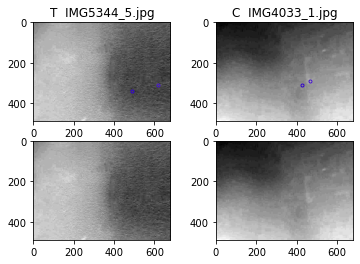

  2%|▎         | 1/40 [00:03<02:02,  3.13s/it]

Not enough point for essential matrix computation


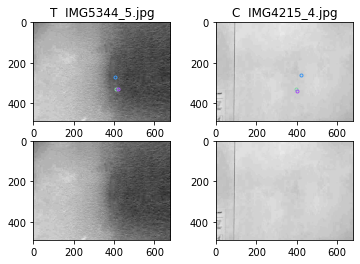

  5%|▌         | 2/40 [00:06<02:01,  3.21s/it]

Not enough point for essential matrix computation


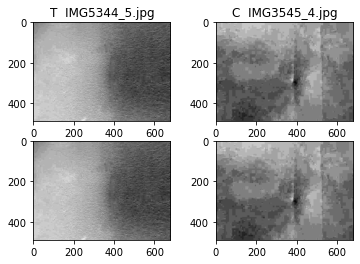

  8%|▊         | 3/40 [00:09<02:03,  3.33s/it]

Not enough point for essential matrix computation


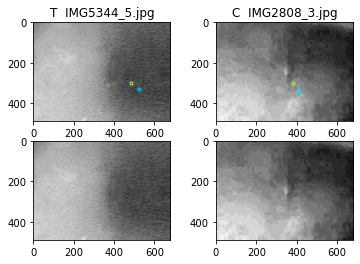

 10%|█         | 4/40 [00:12<01:56,  3.22s/it]

Not enough point for essential matrix computation


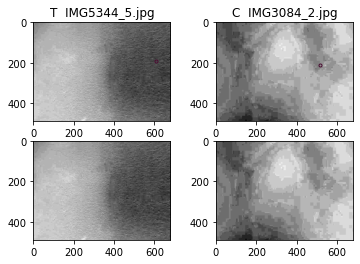

 12%|█▎        | 5/40 [00:15<01:50,  3.16s/it]

Not enough point for essential matrix computation


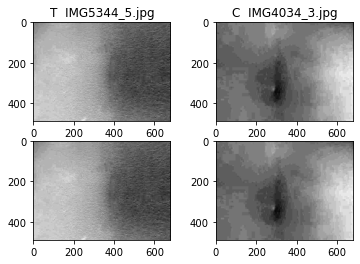

 15%|█▌        | 6/40 [00:18<01:45,  3.11s/it]

Not enough point for essential matrix computation


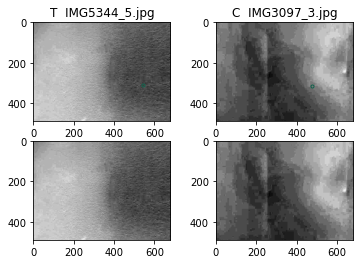

 18%|█▊        | 7/40 [00:22<01:42,  3.09s/it]

Not enough point for essential matrix computation


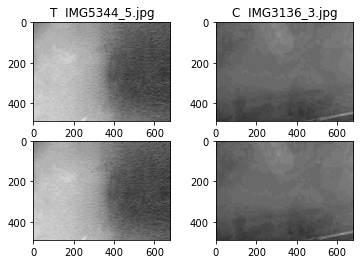

 20%|██        | 8/40 [00:24<01:37,  3.04s/it]

Not enough point for essential matrix computation


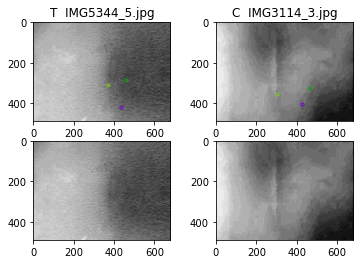

 22%|██▎       | 9/40 [00:28<01:34,  3.04s/it]

Not enough point for essential matrix computation


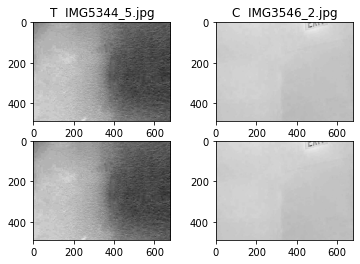

 25%|██▌       | 10/40 [00:30<01:30,  3.00s/it]

Not enough point for essential matrix computation


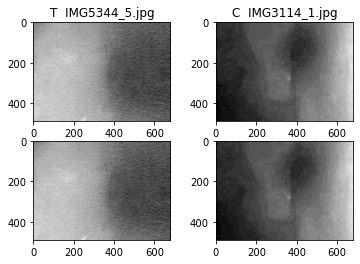

 28%|██▊       | 11/40 [00:33<01:26,  2.99s/it]

Not enough point for essential matrix computation


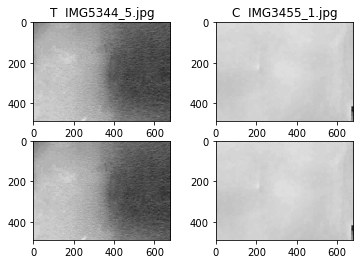

 30%|███       | 12/40 [00:36<01:24,  3.01s/it]

Not enough point for essential matrix computation


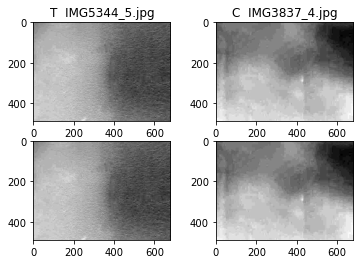

 32%|███▎      | 13/40 [00:39<01:20,  2.99s/it]

Not enough point for essential matrix computation


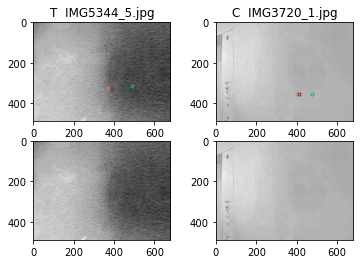

 35%|███▌      | 14/40 [00:42<01:18,  3.02s/it]

Not enough point for essential matrix computation


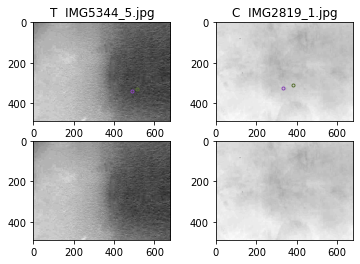

 38%|███▊      | 15/40 [00:46<01:15,  3.04s/it]

Not enough point for essential matrix computation


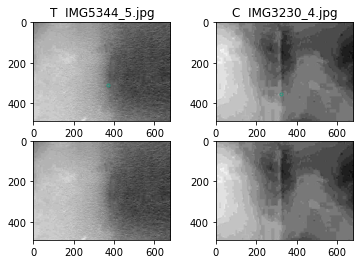

 40%|████      | 16/40 [00:49<01:13,  3.05s/it]

Not enough point for essential matrix computation


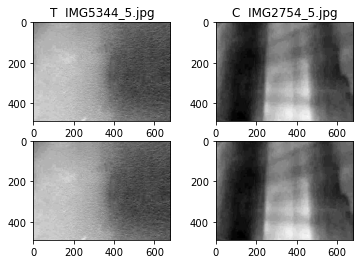

 42%|████▎     | 17/40 [00:52<01:09,  3.01s/it]

Not enough point for essential matrix computation


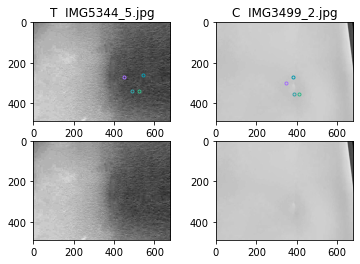

 45%|████▌     | 18/40 [00:55<01:07,  3.07s/it]

Not enough point for essential matrix computation


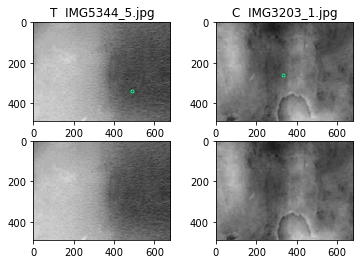

 48%|████▊     | 19/40 [00:58<01:04,  3.07s/it]

Not enough point for essential matrix computation


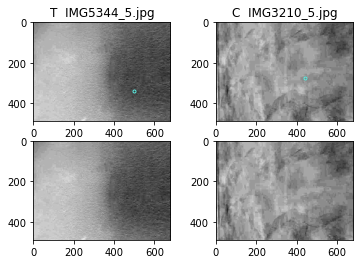

 50%|█████     | 20/40 [01:01<01:01,  3.08s/it]

Not enough point for essential matrix computation


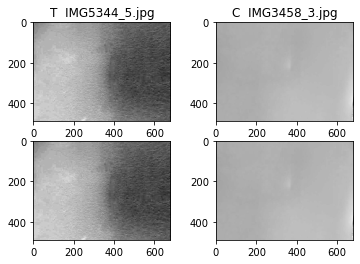

 52%|█████▎    | 21/40 [01:04<00:57,  3.04s/it]

Not enough point for essential matrix computation


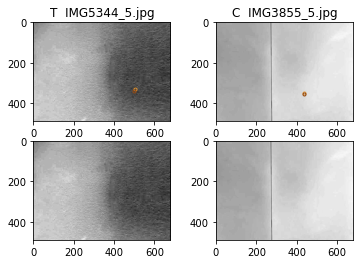

 55%|█████▌    | 22/40 [01:07<00:54,  3.04s/it]

Not enough point for essential matrix computation


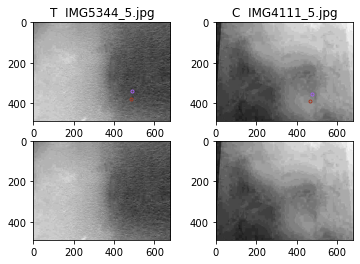

 57%|█████▊    | 23/40 [01:10<00:51,  3.05s/it]

Not enough point for essential matrix computation


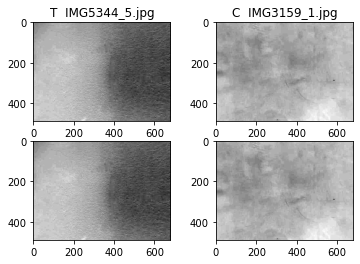

 60%|██████    | 24/40 [01:13<00:48,  3.05s/it]

Not enough point for essential matrix computation


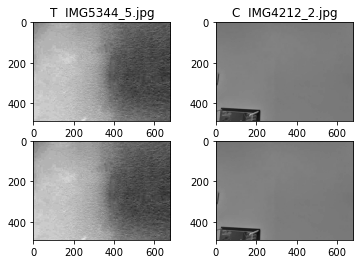

 62%|██████▎   | 25/40 [01:16<00:45,  3.01s/it]

Not enough point for essential matrix computation


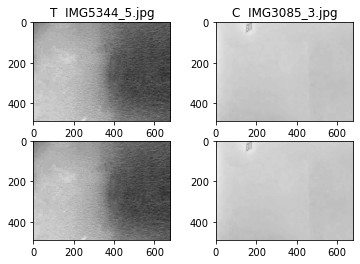

 65%|██████▌   | 26/40 [01:19<00:41,  2.99s/it]

Not enough point for essential matrix computation


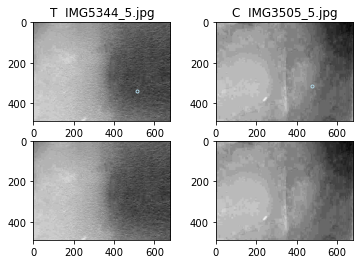

 68%|██████▊   | 27/40 [01:22<00:39,  3.01s/it]

Not enough point for essential matrix computation


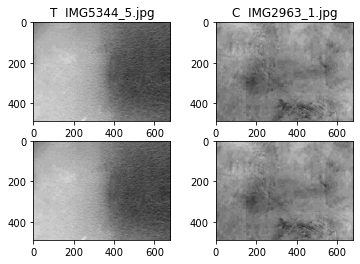

 70%|███████   | 28/40 [01:25<00:35,  2.99s/it]

Not enough point for essential matrix computation


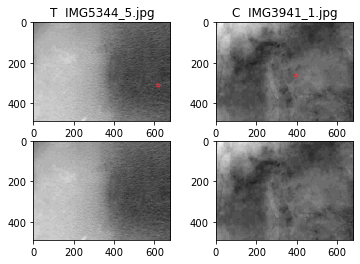

 72%|███████▎  | 29/40 [01:28<00:33,  3.01s/it]

Not enough point for essential matrix computation


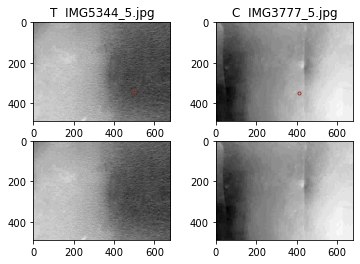

 75%|███████▌  | 30/40 [01:31<00:30,  3.05s/it]

Not enough point for essential matrix computation


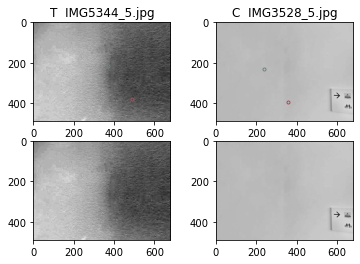

 78%|███████▊  | 31/40 [01:34<00:27,  3.06s/it]

Not enough point for essential matrix computation


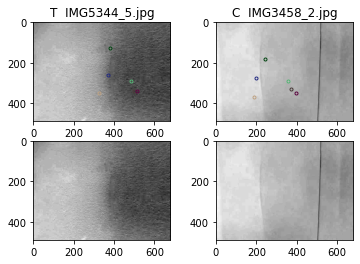

 80%|████████  | 32/40 [01:37<00:24,  3.06s/it]

Number of point used to find essential matrix 5
Number of point used to recover pose 5


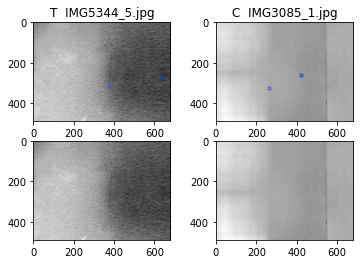

 82%|████████▎ | 33/40 [01:40<00:21,  3.07s/it]

Not enough point for essential matrix computation


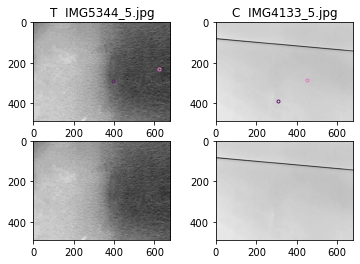

 85%|████████▌ | 34/40 [01:43<00:18,  3.06s/it]

Not enough point for essential matrix computation


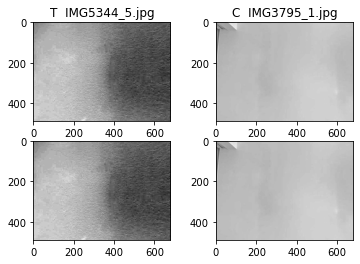

 88%|████████▊ | 35/40 [01:46<00:15,  3.02s/it]

Not enough point for essential matrix computation


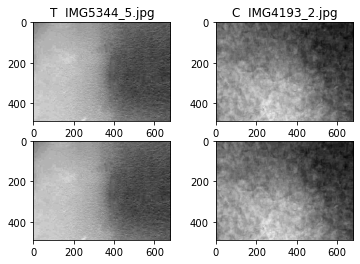

 90%|█████████ | 36/40 [01:49<00:12,  3.03s/it]

Not enough point for essential matrix computation


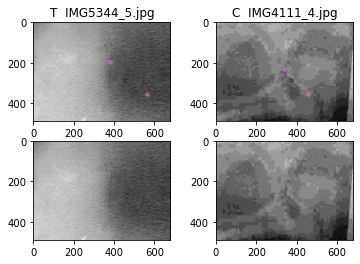

 92%|█████████▎| 37/40 [01:52<00:09,  3.04s/it]

Not enough point for essential matrix computation


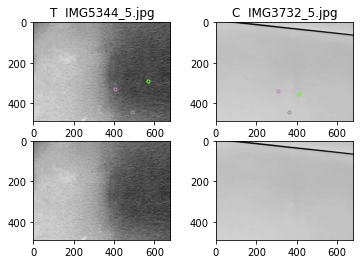

 95%|█████████▌| 38/40 [01:55<00:06,  3.05s/it]

Not enough point for essential matrix computation


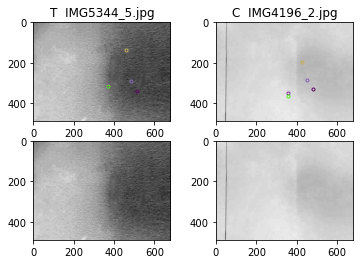

 98%|█████████▊| 39/40 [01:59<00:03,  3.05s/it]

Not enough point for essential matrix computation


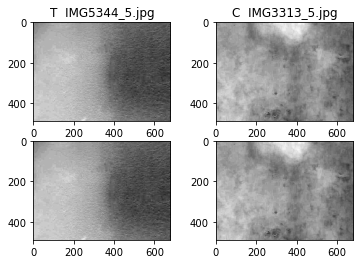

100%|██████████| 40/40 [02:02<00:00,  3.05s/it]

Not enough point for essential matrix computation


In [38]:
%%script false --no-raise-error 
# Examine some images
#IMG4317_2
#IMG5344_5
img_name = 'IMG5344_5.jpg'
_, img = test_dataset_original_size.get_item_by_imgName(img_name)
(predict_x_recover, predict_y_recover, predict_x_E, predict_y_E) = predict_xy_from_camera_pose(img_name, img, test_sim_dic, img_name_to_exclude=[], n_top=40, loftr_threshold = 0, flag_plot = True)